# Haplotype analysis *Coeaexg*

### Color palettes

In [1]:
# define dictionary of pop colors
pop_colours = {
 'Moshi' : "lightgreen",
 'Muleba' : "darkgreen",
}

dup_colours = {
    'Dup present' : 'mediumorchid',
    'Dup absent' : 'lightgray',
}


### Import packages

In [2]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import re
import scipy.cluster
from scipy.stats import spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns



### Load CNV data

In [3]:
# Identify samples that have Cyp6_Dup31
disc_cnv_fn = '../Ag1000G_CNV_data/v3.7_1246-VO-TZ-KABULA-VMF00185/target_regions_analysis/focal_region_CNV_table_extras.csv'
discordant_read_calls = pd.read_csv(disc_cnv_fn, sep = '\t', index_col = 0)
has_Dup = discordant_read_calls['Coeaexg_Dup1'].values
Dup_calls = has_Dup.astype('int')


### Load metadata

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

sample_sets = ['1246-VO-TZ-KABULA-VMF00185']
meta = ag3.sample_metadata(sample_sets = sample_sets).set_index('sample_id')
meta['location'] = meta['location'].str.replace('_.*', '', regex=True)

# Make sure the samples are in the same order as the CNV data (they should be anyway, but 
# just in case)
meta = meta.loc[discordant_read_calls.index, :]

# Get haplotype-level metadata
hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis = 0))
hap_meta.columns = meta.columns
hap_meta.index = [np.repeat(meta.index, 2)[i] + ['a', 'b'][i%2] for i in range(len(hap_meta))]
hap_meta


Load sample metadata:   0%|          | 0/1 [00:00<?, ?it/s]

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,...,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter
VBS54893-6781STDY12150017a,EA18-0001,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54893-6781STDY12150017b,EA18-0001,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54894-6781STDY12150018a,EA18-0003,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54894-6781STDY12150018b,EA18-0003,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54895-6781STDY12150019a,EA18-0004,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBS55420-6781STDY12150539b,EA18-0573,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3
VBS55421-6781STDY12150540a,EA18-0575,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3
VBS55421-6781STDY12150540b,EA18-0575,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3
VBS55422-6781STDY12150541a,EA18-0576,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3


### Load the haplotype data

In [5]:
region='2L:37000000-37500000'

haps = (
    ag3.haplotypes(region = region, 
                   analysis = 'arab', 
                   sample_sets = sample_sets)
    .set_index(samples = 'sample_id')
    .sel(samples = discordant_read_calls.index)
)

In [6]:
# Create haplotype array
hap_array = allel.GenotypeArray(haps.call_genotype).to_haplotypes()

# Get allele counts
ac = hap_array.count_alleles()

# Identify segregating non-singletons. 
non_singleton = ac.min(1) > 1

# Filter the datasets, removing non-segregating and singleton variants 
haps = haps.isel(variants = np.where(non_singleton)[0])
hap_array = hap_array[non_singleton]


In [7]:
# Get the SNP genotypes coded as 0, 1, 2 (wt, het, homozygote mutant). Since all phased SNPs
# are biallelic, this is a suitable way to code genotype. 
genotypes = haps.call_genotype.values.sum(2)
genotypes

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Identify proxy SNPs

In [8]:
# We look for SNPs whose presence / absence patterns are perfectly correlated with Dup31. 
SNP_cor = np.apply_along_axis(lambda x: spearmanr((x>0).astype('int'), 
                                                  Dup_calls), 
                                    1, 
                                    genotypes)[:, 0]
print(f'The maximum correlation coefficient with the Dup is {np.nanmax(SNP_cor)}')

/home/eric/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


The maximum correlation coefficient with the Dup is 1.0


In [9]:
# We have some perfecty associated SNPs. How many are there?
print(f'{np.sum(SNP_cor == 1)} SNPs are perfectly correlated with Dup10 at the presence / absence level.')

1 SNPs are perfectly correlated with Dup10 at the presence / absence level.


In [10]:
Dup_proxy = genotypes[np.where(SNP_cor == 1)[0][0]]

# Let's look at the association of zygosity at those SNPs and copy number. 
#print('Association of Dup proxy zygosity and Dup copy number in Moshi:')
display(
    pd.crosstab(Dup_calls[(meta.location == 'Moshi').values],
                Dup_proxy[(meta.location == 'Moshi').values])
)

print('Association of Dup proxy zygosity and Dup copy number in Muleba:')
display(
    pd.crosstab(Dup_calls[(meta.location == 'Muleba').values],
                Dup_proxy[(meta.location == 'Muleba').values])
)

col_0,0,1,2
row_0,,,
0,18,0,0
1,0,106,163


Association of Dup proxy zygosity and Dup copy number in Muleba:


col_0,0,1
row_0,,
0,170,0
1,0,10


It looks like we have found a good SNP proxy for Cyp9k1_Dup10. Since these SNPs are phased, we now have haplotype-level data for this CNV. 

In [11]:
# Get the haplotypes rather than genotypes for the Dup proxy
Dup_hap_proxy = hap_array[np.where(SNP_cor == 1)[0][0]]
Dup_hap_proxy

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,

### Haplotype plotting functions

In [12]:
def find_clusters(dist, n, threshold=0.001, method='complete'):
        # build hierarchy
        clust = scipy.cluster.hierarchy.linkage(dist, method=method)
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(clust, threshold,
                                             criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        return clusters

# Some plotting functions
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

def plot_dendrogram(zhier, ax, h, method='complete', color_threshold=0, above_threshold_color='k'):

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(zhier, no_labels=True, count_sort=True,
                                           color_threshold=color_threshold,
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-.0001)

    ax.set_ylabel(r'$d_{xy}$')
    ax.autoscale(axis='x', tight=True)
    return r

def draw_hap_cluster_plot(z, r, h, 
                          pop_colour_scheme, cnv_colour_scheme, 
                          labels_for_pop_colours, labels_for_cnv_colours, 
                          cnv_name,
                          add_legend = True, title = '',
                          fn = None):

    gs = GridSpec(3, 1, height_ratios=[6.0, 0.5, 0.5])
    fig = plt.figure(figsize=(15, 5))

    plt.subplots_adjust(hspace=0.02)
    ax1 = plt.subplot(gs[0])
    sns.despine(ax=ax1, offset=5, bottom=True, top=True)
    _ = plot_dendrogram(z, ax1, h)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylim(0)

    ax_pops = fig.add_subplot(gs[1])

    x_pop = labels_for_pop_colours.take(r['leaves'])
    hap_pop_clrs = [pop_colour_scheme[p] for p in x_pop]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                        yrange=(0, 1),
                        color=hap_pop_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')
    
    ax_cnv = fig.add_subplot(gs[2])

    x_cnv = labels_for_cnv_colours.take(r['leaves'])
    hap_cnv_clrs = [cnv_colour_scheme[p] for p in x_cnv]
    ax_cnv.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                       yrange=(0, 1),
                       color=hap_cnv_clrs);
    sns.despine(ax=ax_cnv, offset=5, left=True, bottom=True, top=True)

    ax_cnv.set_xticks([])
    ax_cnv.set_yticks([])
    ax_cnv.set_xlim(0, h.shape[1])
    ax_cnv.yaxis.set_label_position('left')
    ax_cnv.set_ylabel(cnv_name, rotation=0, ha='right', va='center')

    if add_legend:
        plot_x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
        plot_y_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
        legend_x = ax1.get_xlim()[0] + plot_x_range * 0.95
            
        unique_label_cnv = np.unique(x_cnv)
        for i, k in enumerate(unique_label_cnv[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * i)
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = cnv_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)

        
        unique_label_pop = np.unique(x_pop)
        for j, k in enumerate(unique_label_pop[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * (i + 2 + j))
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = pop_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)



    ax1.set_title(f'{title}')
    ax1.autoscale()
    fig.patch.set_alpha(1)
    
    if fn != None:
        ext = re.sub('.*\.', '', fn)
        plt.savefig(fn, format = ext)




### Haplotype clustering

In [13]:
# Home in on the 500 SNPs around the region of interest
focal_pos = 37288789 # Middle of Coeaexg CNV
window_size = 500  # Measured in SNPs


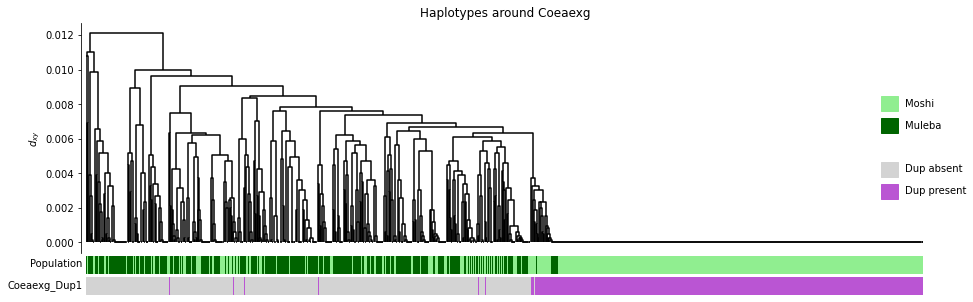

In [14]:
nearest_snp_index = np.argmin(np.abs(haps.variant_position - focal_pos).values)
haptree_region_indices = range(nearest_snp_index - window_size//2, nearest_snp_index + window_size//2)
haptree_region = '2L:' + '-'.join(haps.isel(variants = haptree_region_indices).variant_position.values[[0,-1]].astype('str'))
loc_hap = hap_array[haptree_region_indices]
# loc_hap is the haplotype array for just those 500 SNPs. 

# Calculate the distance matrix 
dist = allel.pairwise_distance(loc_hap, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region, sample_sets="3.7")['variant_filter_pass_arab']
n_bases = np.sum(site_filter.values)
dist_dxy = dist * loc_hap.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup_hap_status = np.array(['Dup absent', 'Dup present'])[Dup_hap_proxy]
draw_hap_cluster_plot(z, r, loc_hap, 
                      pop_colour_scheme = pop_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta['location'], 
                      labels_for_cnv_colours = Dup_hap_status, 
                      cnv_name = 'Coeaexg_Dup1',
                      title = 'Haplotypes around Coeaexg',
                      fn = 'Coeaexg_haplotype_clustering.png'
)